In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights

# utils specific to quantization
from utils import train, quantize, initial_scales
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_densenet import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

# load pretrained model, accuracy ~85%
model.load_state_dict(torch.load('../densenet/model121.pytorch_state'))

#### Keep copy of full precision kernels

In [9]:
# copy all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[2]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

# optimizer for updating only all_fp_kernels
optimizer_fp = optim.SGD(all_fp_kernels, lr=1e-3)

#### initial quantization 

In [10]:
# scaling factors for each quantized layer
scaling_factors = []

In [11]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[2]['params']]

In [12]:
 for k, k_fp in zip(all_kernels, all_fp_kernels):
    
    # choose initial scaling factors 
    w_p_initial, w_n_initial = initial_scales(k_fp.data)
    scaling_factors += [(w_p_initial, w_n_initial)]
    
    # do quantization, this uses hyperparameter t defined in utils.py file
    k.data = quantize(k_fp.data, w_p_initial, w_n_initial)

# Train

In [13]:
n_epochs = 12
n_batches = ceil(train_size/batch_size)
n_batches

531

In [14]:
%%time
all_losses, _ = train(
    model, scaling_factors, criterion, 
    optimizer, optimizer_fp,
    train_iterator, n_epochs, n_batches,
    val_iterator, validation_step=531, n_validation_batches=80
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  3.000 1.776  0.361 0.583  0.620 0.826  251.334
2.00  2.032 1.535  0.535 0.635  0.788 0.855  246.075
3.00  1.767 1.432  0.585 0.662  0.829 0.863  245.404
4.00  1.623 1.361  0.616 0.676  0.847 0.876  245.372
5.00  1.543 1.316  0.637 0.681  0.854 0.878  243.982
6.00  1.462 1.307  0.659 0.684  0.868 0.882  245.113
7.00  1.381 1.270  0.665 0.698  0.878 0.889  244.806
8.00  1.363 1.248  0.670 0.703  0.878 0.888  244.124
9.00  1.307 1.220  0.683 0.706  0.884 0.893  244.078
10.00  1.280 1.210  0.687 0.706  0.890 0.894  243.406
11.00  1.248 1.202  0.696 0.713  0.893 0.895  244.256
12.00  1.209 1.205  0.705 0.709  0.897 0.892  244.885
CPU times: user 48min, sys: 8min 2s, total: 56min 3s
Wall time: 49min 2s


# Loss/epoch plots

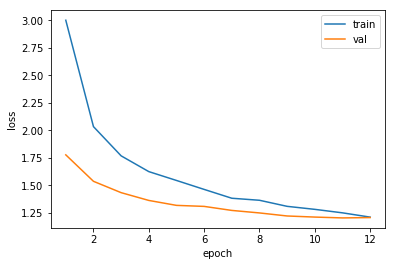

In [15]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

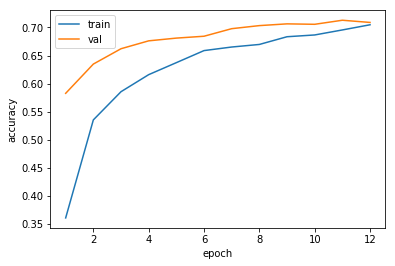

In [16]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

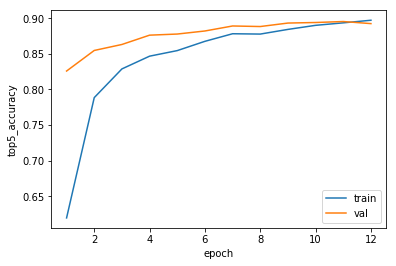

In [17]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [18]:
model.cpu();
torch.save(model.state_dict(), 'model_ternary_quantization.pytorch_state')